In [2]:
# set up
import pandas as pd
import numpy as np
import pickle
import time 
import os
import matplotlib.pyplot as plt
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
data_folder_path = 'C:\\Users\\goodluck\\Desktop\\DB'
raw_data_path =  "C:\\Users\\goodluck\\Desktop\\DB\\raw_data"
storage_path =  "C:\\Users\\goodluck\\Desktop\\DB\\database_storage"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")

# re-open
with open(DTBS_path, 'rb') as f:  
    DTBS = pickle.load(f)

In [18]:
# helper

def select_industry(DTBS, iid):
    TS = dict()

    for one_iid in iid:
        count = 0
        for code in list(DTBS['A'].keys()):
            if DTBS['B'][code]['cat1'] == one_iid:
                TS[code] = DTBS['A'][code]
                count += 1
        print(one_iid, count)
    
    return TS

def takeSecond(elem):
    return elem[1]


def retrieve_low_nodes(TS, codes, days, index, sel_num):
    dl_rank = []
    for code in codes:
        dl_rank.append((code, TS[code][days[index]]['dl']))
        
        dl_rank.sort(key=takeSecond)    
    low = dl_rank[0:sel_num]
    return [j[0] for j in low]

def win_rt(res):
    print("For each transaction:")
    print("Max profit", max(res))
    print("Max loss", min(res))
    wins = []
    win = 0
    for i in res:
        if i >= 0:
            win += 1
            wins.append(True)
        else:
            wins.append(False)
        
    win_rate = win/len(res)
    print("Rate of wins", win_rate)
    print("Info for each transaction", wins)
    
def select_existing(PTS, dt):
    exist = []
    for code in list(PTS.keys()):
        if not np.isnan(PTS[code][dt]['dp']):
            exist.append(code)
    return exist

def select_condition(PTS, codes, dt, name, low, high):
    satisfy = []
    for code in codes:
        if PTS[code][dt][name] <= high:
            if PTS[code][dt][name] >= low:
                satisfy.append(code)
    return satisfy


def sel_dts(DD, st, ed, tp):
    dts = []
    stdt = datetime.strptime(st, '%Y-%m-%d').date()
    eddt = datetime.strptime(ed, '%Y-%m-%d').date()
    for time in DD[tp]:
        dt = datetime.strptime(time, '%Y-%m-%d').date()
        if dt >= stdt:
            if dt <= eddt:
                dts.append(time)
    return dts

def all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit = []
    sum_dl = 0
    all_codes = []
    res = []
    if sel_ct == 1:
        TS = select_industry(DTBS, ct)
    else:
        TS = DTBS['A']
    for i in range(len(days)):  
#         if sel_dl == 1:
#             curr_dl_codes = retrieve_low_nodes(TS, days, i, sel_num)
#         else:
#             curr_dl_codes = select_existing(TS, days[i])

#         curr_dl_codes = select_existing(TS, days[i])

        if i+1 == len(days):
            curr_dl_codes = select_existing(TS, days[i])

            if sel_cd1 == 1:
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)                
            
        else: 
            ctw = select_existing(TS, days[i])
            cnw = select_existing(TS, days[i+1])
            curr_dl_codes = list(set(ctw).intersection(set(cnw)))
            
                
            if sel_cd1 == 1:
                curr_dl_codes = select_condition(TS, curr_dl_codes, days[i], sel_nm1, sel_low1, sel_high1)
            if sel_dl == 1:
                curr_dl_codes = retrieve_low_nodes(TS, curr_dl_codes, days, i, sel_num)
#         print(len(curr_dl_codes))
        all_codes.append(curr_dl_codes)
        if i >= 1:
        
            tw = 0
            lw = 0
            for cd in all_codes[i-1]:
                tw += TS[cd][days[i]]['dp']
        
        
            for cd in all_codes[i-1]:
                lw += TS[cd][days[i-1]]['dp']
        
            re = ((tw - lw)/ lw)
            res.append(re)
            sum_dl += re
        
            profit.append(sum_dl)
    return profit, res
    

def plot_str(days, profit,tick_spacing = 4.5, market = DTBS['C']):
    plt.figure()
    fig, ax = plt.subplots(1,1)
    plt.plot(days[1:], profit)
    # ewi
    i_x = [days[1], days[-1]]
#     print(market['zi'][days[-1]], market['zi'][days[0]])

    market_gain = (market['zi'][days[-1]]-market['zi'][days[0]])/(market['zi'][days[0]])
    i_y = [0, market_gain]
    plt.plot(i_x, i_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.ylabel('Increase per year/%')
    plt.show()
    print("Final gain", profit[-1])
    print("Market index", market_gain)

def start(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1):
    profit, res = all_profit(DTBS, days, ct, sel_ct, sel_dl, sel_num, sel_cd1, sel_nm1, sel_low1, sel_high1)
    plot_str(days, profit)
    win_rt(res)

f2020 = sel_dts(DTBS['D'],'2020-01-01','2020-06-30','mon')
s2020 = sel_dts(DTBS['D'],'2020-07-01','2020-12-31','mon')
f2021 = sel_dts(DTBS['D'],'2021-01-01','2021-06-30','mon')
s2021 = sel_dts(DTBS['D'],'2021-07-01','2021-12-31','mon')
f2022 = sel_dts(DTBS['D'],'2022-01-01','2022-06-30','mon')
s2022 = sel_dts(DTBS['D'],'2022-07-01','2022-12-31','mon')
a2023 = sel_dts(DTBS['D'],'2023-01-01','2023-3-22','mon')
a2020 = sel_dts(DTBS['D'],'2020-01-01','2020-12-31','mon')
a2022 = sel_dts(DTBS['D'],'2022-01-01','2022-12-31','mon')
a2021 = sel_dts(DTBS['D'],'2021-01-01','2021-12-31','mon')



<Figure size 432x288 with 0 Axes>

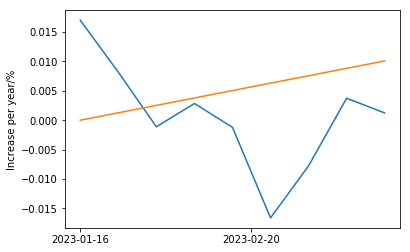

Final gain 0.0012313815361293195
Market index 0.010072105706597593
For each transaction:
Max profit 0.016988231585391332
Max loss -0.015395911622343722
Rate of wins 0.4444444444444444
Info for each transaction [True, False, False, True, False, False, True, True, False]


In [34]:
start(DTBS, a2023, [], 0, 1, 5, 1, 'trt', 2, 10)


In [150]:
s2020
a2023[-1]

'2023-03-20'

In [105]:
DTBS['A']['113545.SH']

{'2017-01-03': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-04': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-05': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-06': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-09': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-10': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-11': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-12': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-13': {'cpr': nan,
  'dp': nan,
  'bl': nan,
  'trt': nan,
  'ytm': nan,
  'yl': nan,
  'dl': 999},
 '2017-01-16': {'cp

In [104]:
list(DTBS['A'].keys())

['110088.SH',
 '113545.SH',
 '113631.SH',
 '123128.SZ',
 '123156.SZ',
 '127027.SZ',
 '127061.SZ',
 '110047.SH',
 '110063.SH',
 '110070.SH',
 '110087.SH',
 '110089.SH',
 '110092.SH',
 '111001.SH',
 '111002.SH',
 '111003.SH',
 '111007.SH',
 '111012.SH',
 '113025.SH',
 '113027.SH',
 '113046.SH',
 '113047.SH',
 '113058.SH',
 '113059.SH',
 '113064.SH',
 '113534.SH',
 '113535.SH',
 '113566.SH',
 '113591.SH',
 '113600.SH',
 '113615.SH',
 '113621.SH',
 '113623.SH',
 '113632.SH',
 '113636.SH',
 '113638.SH',
 '113640.SH',
 '113641.SH',
 '113649.SH',
 '113650.SH',
 '113653.SH',
 '113657.SH',
 '113663.SH',
 '118000.SH',
 '118005.SH',
 '118006.SH',
 '118008.SH',
 '118010.SH',
 '118018.SH',
 '118020.SH',
 '118022.SH',
 '118023.SH',
 '118028.SH',
 '118029.SH',
 '123012.SZ',
 '123013.SZ',
 '123031.SZ',
 '123046.SZ',
 '123052.SZ',
 '123057.SZ',
 '123076.SZ',
 '123078.SZ',
 '123085.SZ',
 '123091.SZ',
 '123106.SZ',
 '123118.SZ',
 '123124.SZ',
 '123126.SZ',
 '123129.SZ',
 '123144.SZ',
 '123152.SZ',
 '1231

In [108]:
2 in range(0,10)

True

In [164]:
DTBS['C']['zi']['2023-03-20'] = np.float64(DTBS['C']['zi']['2023-03-20'])
DTBS['C']['zi']['2023-03-21'] = np.float64(DTBS['C']['zi']['2023-03-21'])
DTBS['C']['zi']['2023-03-22'] = np.float64(DTBS['C']['zi']['2023-03-22'])

In [165]:
# save
f_save = open(DTBS_path, 'wb')
pickle.dump(DTBS, f_save)
f_save.close()


In [161]:
type(np.float64(411.2))

numpy.float64